## QuasarNET Performance vs nchunks
#### Plot to show performance of QuasarNET as a function of the number of boxes/chunks
xxx

In [1]:
import astropy
import copy
import glob
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
figsize = (12,6.5)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different QN models

In [3]:
## QN parameters
n_detect = 1
c_th = 0.8
include_c_qn = True
common_specids = True

In [4]:
f_truth = variables.OUTDIR+'/data/truth/truth_dr12q.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

for nchunks in variables.NCHUNK_VALUES:

    ## Load the QN using nchunks value.
    f_qn = glob.glob(variables.OUTDIR+'/outputs/qn_outputs/additional_setups/nchunks/nchunks_{}/qnAll*.fits'.format(nchunks))[0]

    data['QN_{}'.format(nchunks)] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [6]:
data_table = utils.reduce_data_to_table(data,truth,include_c_qn=include_c_qn,common_specids=common_specids)
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_QN_7,CLASS_QN_7,ISQSO_QN_7,C_QN_7 [6],Z_LINES_QN_7 [6],Z_QN_10,CLASS_QN_10,ISQSO_QN_10,C_QN_10 [6],Z_LINES_QN_10 [6],Z_QN_13,CLASS_QN_13,ISQSO_QN_13,C_QN_13 [6],Z_LINES_QN_13 [6],Z_QN_16,CLASS_QN_16,ISQSO_QN_16,C_QN_16 [6],Z_LINES_QN_16 [6],Z_QN_19,CLASS_QN_19,ISQSO_QN_19,C_QN_19 [6],Z_LINES_QN_19 [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64,float64,str8,bool,float64,float64
7166566020362,20589337,2,1.616,QSO,True,1.638,NONQSO,False,0.008 .. 0.000,2.244 .. -0.157,1.663,NONQSO,False,0.000 .. 0.000,2.186 .. 0.035,1.623,NONQSO,False,0.002 .. 0.000,2.110 .. 0.479,1.656,QSO,True,0.000 .. 0.000,2.648 .. 0.398,1.628,NONQSO,False,0.049 .. 0.000,2.230 .. -0.350
7169566280047,20935261,2,0.000,STAR,False,2.267,NONQSO,False,0.000 .. 0.000,5.314 .. -0.349,2.385,NONQSO,False,0.000 .. 0.000,5.321 .. -0.332,2.300,NONQSO,False,0.000 .. 0.000,2.103 .. 0.167,1.348,NONQSO,False,0.000 .. 0.000,2.960 .. -0.195,2.255,NONQSO,False,0.000 .. 0.000,2.335 .. 0.253
7169566280046,20935742,2,0.000,STAR,False,4.642,NONQSO,False,0.000 .. 0.000,4.642 .. 0.441,1.517,NONQSO,False,0.000 .. 0.000,3.670 .. 0.439,1.436,NONQSO,False,0.000 .. 0.000,4.690 .. 0.445,0.555,NONQSO,False,0.000 .. 0.000,2.900 .. 0.460,1.973,NONQSO,False,0.000 .. 0.000,4.404 .. 0.471
7169566280052,20936956,2,0.000,STAR,False,1.393,NONQSO,False,0.000 .. 0.000,5.497 .. -0.347,3.900,NONQSO,False,0.000 .. 0.000,3.845 .. 0.158,1.805,NONQSO,False,0.000 .. 0.000,3.208 .. 0.155,2.997,NONQSO,False,0.000 .. 0.000,2.957 .. -0.176,3.286,NONQSO,False,0.000 .. 0.000,4.413 .. -0.067
7169566280088,20938894,2,0.000,STAR,False,1.790,NONQSO,False,0.000 .. 0.000,4.767 .. -0.370,0.155,NONQSO,False,0.000 .. 0.000,3.848 .. 0.155,2.202,NONQSO,False,0.000 .. 0.000,2.312 .. 0.088,2.658,NONQSO,False,0.000 .. 0.000,4.788 .. 0.409,0.891,NONQSO,False,0.000 .. 0.000,3.677 .. 0.325


In [7]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
len(data_table)

506217

### Compare the performance of the different model/data combos.
xxx

In [8]:
ls = {'QN_13': '-',
      'QN_19': '--',
      'QN_16': '-.',
      'QN_10': ':',
      'QN_7': (0, (3, 5, 1, 5, 1, 5)),
     }

In [9]:
## Define general parameter values.
dv_max = 6000.

# confidence thresholds.
c_th_min = 0.0
c_th_max = 1.0
n_int = 101
c_th_values = np.linspace(c_th_min,c_th_max,n_int)

In [10]:
## Define strategies.
strategies = {}

for s in data.keys():
    
    nchunks = int(s.split('_')[-1])
    name = r'$n_{{boxes}}={}$'.format(nchunks)
    if type(data_table['ISQSO_{}'.format(s)])==astropy.table.column.MaskedColumn:
        filt = (~data_table['ISQSO_{}'.format(s)].data.mask)
    else:
        filt = np.ones(len(data_table)).astype(bool)
    temp_data_table = data_table[filt]
    
    # QN definitions.
    n_detect = 1
    strat = strategy.Strategy('qn',cf_kwargs={'qn_name':s})
    preds = [strat.predict(temp_data_table,c_kwargs={'c_th':c_th_value,'n_detect':n_detect}) for c_th_value in c_th_values]
    strategies[s] = {'predictions': preds,
                     'n': name, 
                     'ls': ls[s]}

/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:35: RuntimeWarning: invalid value encountered in long_scalars
  pur = pur_num/pur_denom
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:293: RuntimeWarning: invalid value encountered in greater
  ind = np.where(pur>com)[0][0]
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:328: RuntimeWarning: invalid value encountered in greater
  ind = np.where(mean_pur>mean_com)[0][0]


Strategy QN_7:
Crossover occurs at:
cth: [0.05 0.06 0.07 0.08]
pur: [0.99   0.9904 0.9907 0.9909]
com: [0.9908 0.9907 0.9907 0.9906]
QN_7 has median velocity error -5.719 and standard deviation 1023.201

Strategy QN_10:
Crossover occurs at:
cth: [0.09 0.1  0.11 0.12]
pur: [0.9933 0.9935 0.9937 0.9939]
com: [0.9937 0.9936 0.9935 0.9934]
QN_10 has median velocity error -32.209 and standard deviation 825.864

Strategy QN_13:
Crossover occurs at:
cth: [0.08 0.09 0.1  0.11]
pur: [0.9937 0.9939 0.9941 0.9943]
com: [0.9941 0.9939 0.9938 0.9937]
QN_13 has median velocity error 7.438 and standard deviation 804.645

Strategy QN_16:
Crossover occurs at:
cth: [0.07 0.08 0.09 0.1 ]
pur: [0.9938 0.994  0.9943 0.9944]
com: [0.9943 0.9941 0.994  0.9939]
QN_16 has median velocity error -17.775 and standard deviation 739.331

Strategy QN_19:
Crossover occurs at:
cth: [0.08 0.09 0.1  0.11]
pur: [0.994  0.9942 0.9944 0.9946]
com: [0.9946 0.9944 0.9943 0.9942]
QN_19 has median velocity error -0.425 and sta

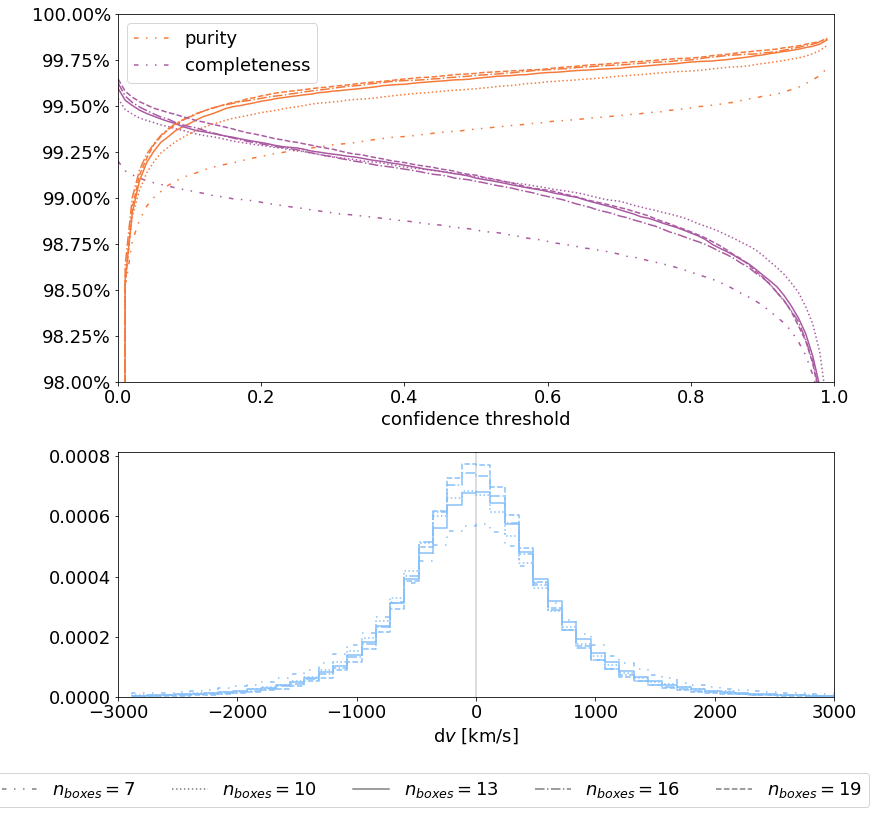

In [11]:
filename = '../plots/qn_performance_vs_nboxes.pdf'

plot.plot_qn_model_compare(data_table,strategies,filename=filename,
                           dv_max=dv_max,nydec=2,figsize=(12,12),
                           ymin=0.98,ymax=1.,verbose=True,npanel=2,
                           norm_dvhist=True,c_th=c_th_values)
plt.show()